In [254]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import matplotlib.colors as col
import itertools
import numpy as np
import scipy as sp
import pandas as pd
import time

from bisect import bisect_left
from copy import deepcopy

## To do:

* Fix cars fusing from different lanes √
* Flow
* Traffic lights
* Flow vs lanes
* Flow vs vmax

In [247]:
class TrafficSimulation():
    
    def __init__(self,road_size,lanes,density,vmax,p_change = 1):
        global cars
        
        self.road_size = road_size #lenght of the displayed road
        self.density = density # how many cars in the simulation as a function of the road length
        self.time_step = 0
        self.lanes = lanes #number of lanes
        self.n_cars = int(self.road_size * self.density) #computes the number of cars
        self.p_change = p_change #probability of changing lanes provided the opportunity and convinience to do so
        self.road = -1*np.ones((lanes,self.road_size)) #road array
        self.states = [] #record of each state of the road array
        self.flow_record = [] #record of the average flow in the array
        
        
        #all_positions = np.array(list(itertools.product(range(self.lanes),range(self.road_size))))
        #self.initial_positions = all_positions[np.random.randint(len(all_positions),size = n_cars)]
        
        #self.initial_positions = np.random.choice(range(self.road_size),self.n_cars,replace=False) #initial x-positions
        
        #initiate n_cars instances of Car(), giving them the pre-computed random positions, vmax, p_change, etc.
        cars = [Car(id=i, position = np.array([np.random.choice(range(self.lanes)),self.initial_positions[i]]),vmax=vmax, p_slow = 0.5, road_size = self.road_size, lanes = self.lanes) for i in range(self.n_cars)]
                
        #map the attributes of the cars into the road array
        for car in cars:
            self.road[tuple(car.position)] = car.v
        
        #keep the positions of all cars at a given time in an array
        self.car_positions = []
        for l in range(self.lanes):
            cars_in_a_lane = list(filter(lambda x : x.position[0] == l, cars)) #list of all cars in a lane
            self.car_positions.append([car.position[1] for car in sorted(cars_in_a_lane, key = lambda x : x.position[1])]) #map their positions

        
    def draw(self): #plot the road array as a colored grid
         
        #custom colormap
        C = np.array([[255,255,255], # white for empty spaces
            [235,198,83], # orange for still cars (to track jams easily)
            [136,230,255], # gradient of blues for faster cars
            [0,200,255],
            [0,145,255],
            [0,92,205],
            [0,57,103]])
        
        cm = col.ListedColormap(C/255.0)
        
        self.fig, self.bars = plt.subplots(1, figsize=(15,7))
        self.bars.cla()
        im = self.bars.imshow(self.road,vmin = -1, vmax = 5, cmap = cm, interpolation='none') #plot road as a grid
        self.bars.axis('image')
        
        if self.lanes <= 3: self.bars.get_yaxis().set_visible(False) #do not plot the y-axis if 3 lanes or fewer
        else: 
            self.bars.set_yticks(range(0,self.road.shape[0]))
            self.bars.tick_params(axis='y', labelsize=7) 
            
        self.bars.set_xticks(range(0,self.road.shape[1]+1,2))
        self.bars.tick_params(axis='x', labelsize=7) 
        
        self.bars.set_title('t = ' + str(self.time_step)) # report the timestep for each plot
        
        if self.time_step == 0: # add a colorbar for reference before the first plot
            cbaxes = self.fig.add_axes([0, 0.7, 0.8, 0.02]) 
            cb = plt.colorbar(self.bars.imshow(self.road,vmin = -1, vmax = 5, cmap = cm)
            , cax = cbaxes, orientation = 'horizontal')  
        
        
        self.fig.subplots_adjust(left=0)
        
    #outputs an mp4 file taking the plotting of each state of the road as the set of frames    
    def animate(self):
        global fig, frames, ani # necessary evil, doesn't work otherwise
        fig, bars = plt.subplots(1, figsize=(9,7))
        plt.yticks([])
        plt.xticks(range(0,self.road.shape[1]+1,4), fontsize=7)
        plt.tight_layout()

        C = np.array([[255,255,255],
            [235,198,83],
            [136,230,255],
            [0,200,255],
            [0,145,255],
            [0,92,205],
            [0,57,103]])
        
        cm = col.ListedColormap(C/255.0)
        frames = [[plt.imshow(s,animated=True,cmap=cm)] for s in self.states] #turn states into frames
        ani = anim.ArtistAnimation(fig, frames, interval=50, blit=True, # animation object
                                        repeat_delay=1000)

    def update_road_map(self): #update the attribute/list 'self.car_positions' created in __init__
        self.car_positions = []
        for l in range(self.lanes):
            cars_in_a_lane = list(filter(lambda x : x.position[0] == l, cars))
            self.car_positions.append([car.position[1] for car in sorted(cars_in_a_lane, key = lambda x : x.position[1])])
    

    def update_simulation(self):
        
        self.time_step += 1 # advance the time count of the simulation
        
        flow_map = np.zeros(self.road_size,dtype=np.int64) # create an array to track the flow on each space
        
        self.update_road_map() # update self.car_positions
        
        for car in cars: #check for lane switches
            car.change_lane()
        
        
        self.update_road_map() #update the road again for v and position updates
        
        for car in cars:
            car.update_v() #update velocities
            
            if car.v > 0: #update flow for each position where the car will step on
                for x in range(car.position[1], (car.position[1] + car.v) % self.road_size):
                    flow_map[car.position[1]] += 1 #add 1 to the position in the flow array
        
        self.flow_record.append(np.mean(flow_map)) #append the spatial average to the time record
        
        for car in cars:
            car.update_position() #update positions
        
    
        #self.draw()
        
        self.road.fill(-1) # clear the road array
        for car in cars:
            self.road[tuple(car.position)] = car.v # update the road array
        
        #append a copy of the road array to the record of states
        self.states.append(deepcopy(self.road)) 
        
        
#################   
        

class Car:
    
    def __init__(self, id, position, vmax, p_slow, road_size, lanes):
        self.id = id
        self.position = position # (x,y) tuple, where x is the lane number
        self.p_slow = p_slow
        self.road_size = road_size
        self.lanes = lanes
        self.v = 1
        self.vmax = vmax
        
    def periodic_distance(self,x,y): # distance between two cars considering only the horizontal component
        return min(abs(x-y), x-y + self.road_size) # correct for circular road
        
    #returns a convinience score for turning left
    def check_left(self):
        # return 0 if already on the leftmost lane                
        if self.position[0] == 0: 
            return 0
        
        left_lane = self.position[0] - 1
        
        #return the index and position of the car in front from
        #the attribute TrafficSimulation.car_positions
        front_idx = bisect_left(sim.car_positions[self.position[0]], self.position[1] + 1) % len(sim.car_positions[self.position[0]])
        front_position = sim.car_positions[self.position[0]][front_idx]
        
        # return the length of the road minus 1 if only car in a lane
        if len(sim.car_positions[self.position[0]]) == 1:
            self.front_gap = self.road_size - 1
        else: #return distance between car in front and car in question otherwise
            self.front_gap = self.periodic_distance(front_position, self.position[1]) - 1
        
        #cars turning right have priority (prevent collisions due to simultaneous turning)
        if self.position[1] in sim.car_positions[left_lane - 1]: 
            return 0
        
        #if no other cars on the left lane, return the difference between the 
        #length of the road minus one and the front gap
        if len(sim.car_positions[left_lane]) == 0:
            return self.road_size - 1 - self.front_gap
        
        #return the index and position of the car that would be in front
        #after turning from the attribute TrafficSimulation.car_positions
        self.left_idx = bisect_left(sim.car_positions[left_lane], self.position[1]) % len(sim.car_positions[left_lane])
        self.left_position = sim.car_positions[left_lane][self.left_idx]
        
        #return the index and position of the car that would be behind
        #after turning from the attribute TrafficSimulation.car_positions
        back_idx = (self.left_idx - 1) % len(sim.car_positions[left_lane])
        back_position = sim.car_positions[left_lane][back_idx]
        
        #define left and back gaps as the distance between the car's
        #position and those of the cars in front and behind after
        #turning
        self.left_gap = self.periodic_distance(self.left_position, self.position[1]) -1
        self.back_gap = self.periodic_distance(back_position, self.position[1]) -1
        
        # if 1) the gap is smaller than the velocity, 2) the 
        # gap would be larger in the left lane, and 3) there
        # is no car coming from the back: set the convenience
        # score as the difference in gaps between the current
        # and the lane on the left
        if self.front_gap < self.v + 1 and self.left_gap > self.v + 1 and self.back_gap > self.vmax:
            return self.left_gap - self.front_gap
        else:
            return 0
        
    #symmetrical to Car.check_left()
    def check_right(self):
        # return 0 if already on the rightmost lane                        
        if self.position[0] == self.lanes - 1:
            self.right_gap = self.road_size - 1 
            return 0
        
        right_lane = self.position[0] + 1
        
        #return the index and position of the car in front from
        #the attribute TrafficSimulation.car_positions
        front_idx = (bisect_left(sim.car_positions[self.position[0]], self.position[1]) + 1) % len(sim.car_positions[self.position[0]])
        front_position = sim.car_positions[self.position[0]][front_idx]

        # return the length of the road minus 1 if only car in a lane        
        if len(sim.car_positions[self.position[0]]) == 1:
            self.front_gap = self.road_size - 1
        else:  #return distance between car in front and car in question otherwise
            self.front_gap = self.periodic_distance(front_position, self.position[1]) - 1

        #if no other cars on the right lane, return the difference  
        #between the length of the road minus one and the front gap            
        if len(sim.car_positions[right_lane]) == 0:
            return self.road_size - 1 - self.front_gap
        
        #return the index and position of the car that would be in front
        #after turning from the attribute TrafficSimulation.car_positions        
        right_idx = bisect_left(sim.car_positions[right_lane], self.position[1]) % len(sim.car_positions[right_lane])
        right_position = sim.car_positions[right_lane][right_idx]
     
        #return the index and position of the car that would be behind
        #after turning from the attribute TrafficSimulation.car_positions    
        back_idx = (right_idx - 1) % len(sim.car_positions[right_lane])
        back_position = sim.car_positions[right_lane][back_idx]

        #define right and back gaps as the distance between the car's
        #position and those of the cars in front and behind after
        #turning        
        self.right_gap = self.periodic_distance(right_position, self.position[1]) -1
        self.back_gap = self.periodic_distance(back_position, self.position[1]) -1
        
        # if 1) the gap is smaller than the velocity, 2) the 
        # gap would be larger in the right lane, and 3) there
        # is no car coming from the back: set the convenience
        # score as the difference in gaps between the current
        # and the lane on the right
        if self.front_gap < self.v + 1 and self.right_gap > self.v + 1 and self.back_gap > self.vmax:
            return self.right_gap - self.front_gap
        else:
            return 0
                                     
    # compare the convenience scores of the lanes on the left and the right
    def change_lane(self):
        # define the scores according to the 2 methods above
        right_gain = self.check_right()
        left_gain = self.check_left()
        
        # if both gains are 0, don't turn
        if right_gain == 0 and left_gain == 0:
            return
        # if turning to either side is convenient, do so
        # with a probability of TrafficSimulation.p_change
        elif right_gain > left_gain:
            if np.random.random() < sim.p_change:
                self.position += np.array([1,0])
        elif left_gain > right_gain:
            if np.random.random() < sim.p_change:
                self.position -= np.array([1,0])
        # if turning to either side is equally convinient, flip a coin
        elif right_gain == left_gain:
            if np.random.random() < sim.p_change:
                self.position +=[np.random.choice([1,-1]),0]
        
        
    def update_v(self):
        #return the index and position of the car in front from
        #the attribute TrafficSimulation.car_positions
        front_idx = (bisect_left(sim.car_positions[self.position[0]], self.position[1]) + 1) % len(sim.car_positions[self.position[0]])
        front_position = sim.car_positions[self.position[0]][front_idx]
        
        # return the length of the road minus 1 if only car in a lane        
        if len(sim.car_positions[self.position[0]]) == 1:
            self.front_gap = self.road_size - 1
        else:  #return distance between car in front and car in question otherwise
            self.front_gap = self.periodic_distance(front_position, self.position[1]) - 1
        
         # detect if two cars have the same position and report it as a crash
        if self.front_gap < 0:
            print('Car {} has crashed at position {} at time {}'.format(self.id, self.position, sim.time_step))
        
        #Rules of velocity updating
        
        # speed up if under the maximum velocity
        if self.v < self.vmax:
            self.v += 1
        # deaccelerate if one could crash if the car in front stops
        if self.v > self.front_gap:
        #advance to the position behind the car in the front
            self.v = self.front_gap 
        # stochastic deacceleration with a probability of Car.p_slow
        if self.v > 0 and np.random.random() < self.p_slow: #rule 3
            self.v -= 1
    
    #update the positions given the new velocities
    def update_position(self):   
        #update the length component
        self.position = (self.position + np.array([0, self.v])) % self.road_size
        
        #return the index and position of the car in front from
        #the attribute TrafficSimulation.car_positions
        front_idx = (bisect_left(sim.car_positions[self.position[0]], self.position[1]) + 1) % len(sim.car_positions[self.position[0]])
        front_position = sim.car_positions[self.position[0]][front_idx]
        
        self.front_gap = self.periodic_distance(front_position, self.position[1]) - 1        

/Users/nico/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


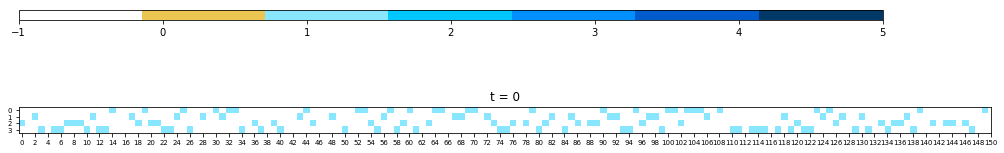

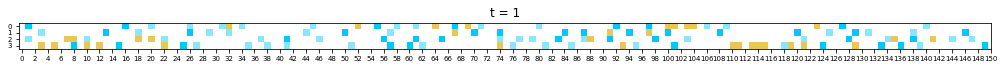

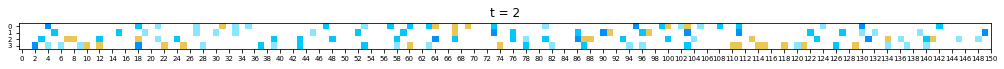

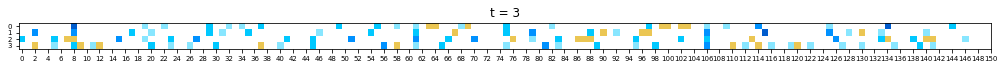

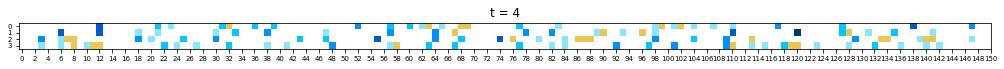

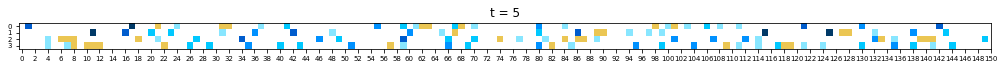

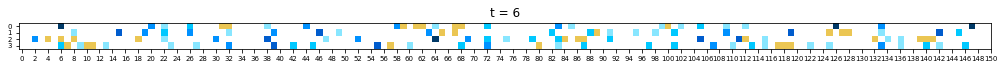

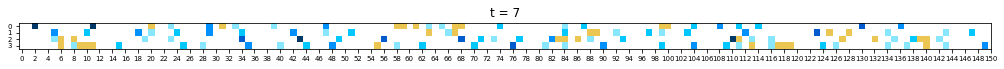

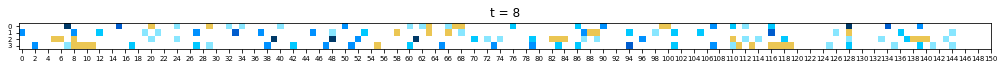

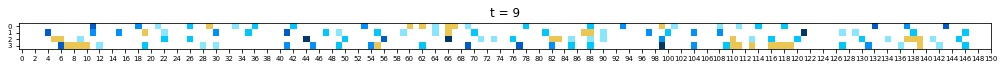

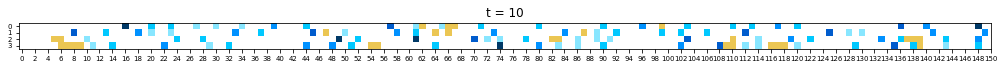

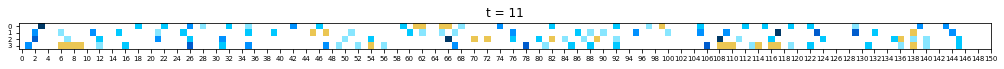

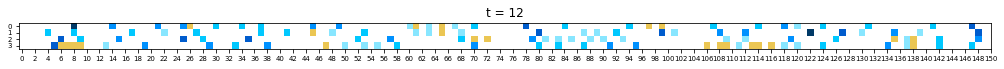

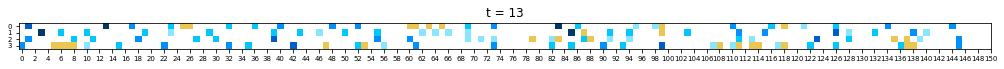

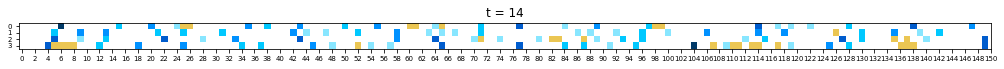

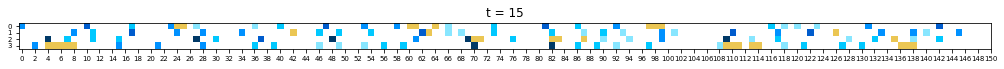

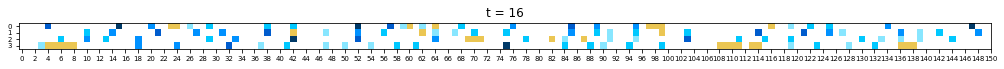

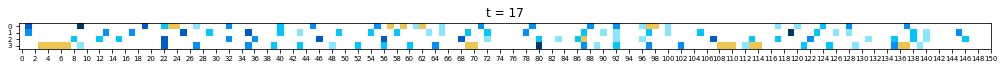

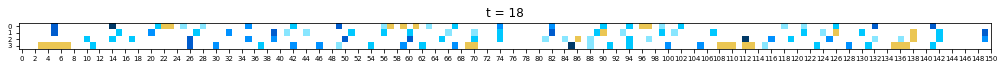

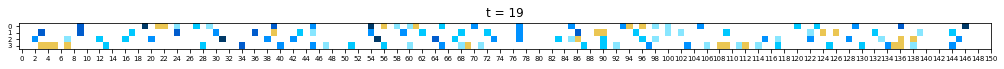

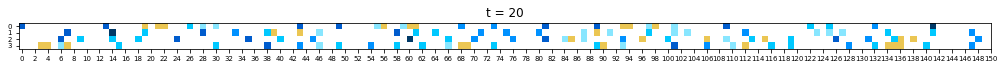

In [248]:
sim = TrafficSimulation(road_size = 150, lanes=4,density = 0.80, vmax = 5, p_change= 0.5)
sim.draw()

for _ in range(20):
    sim.update_simulation()
    sim.draw()


    
# sim.animate()

# Writer = anim.writers['ffmpeg']
# writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)
# ani.save('traffic2d_simulation.mp4',writer=writer)

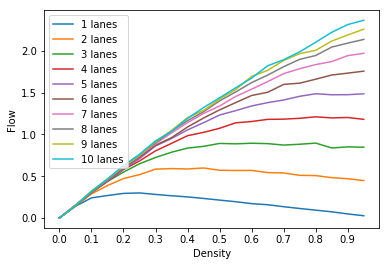

In [186]:
densities = np.array([x*np.ones(20) for x in np.arange(0,1,0.05)]).ravel()
lane_numbers = range(1,11)
flow = [[] for x in lane_numbers]
average_flow = len(lane_numbers)*[0]

for l in lane_numbers:
    for d in densities:
        sim = TrafficSimulation(road_size = 150,lanes=l,density = d, vmax = 5, p_change= 0.2)
        for t in range(10):
            sim.update_simulation()
        flow[l-1].append(np.mean(sim.flow_record))

    density_value, average_flow[l-1] = zip(*sorted((xVal, np.mean([yVal for a, yVal in zip(densities, flow[l-1]) if xVal==a])) for xVal in set(densities)))

    plt.plot(density_value,average_flow[l-1], label='{} lanes'.format(l))

#plt.scatter(densities,flow,c='orange',s=1)
plt.legend()
plt.xticks(np.arange(0,1,0.1))
plt.ylabel('Flow')
plt.xlabel('Density')
plt.show()

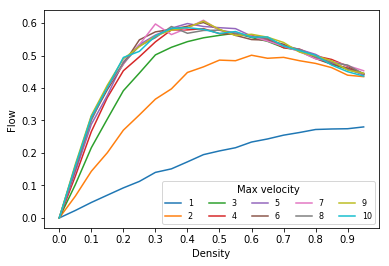

In [222]:
densities = np.array([x*np.ones(20) for x in np.arange(0,1,0.05)]).ravel()
max_velocities = range(1,11)
flow = [[] for x in lane_numbers]
average_flow = len(lane_numbers)*[0]

for m in max_velocities:
    for d in densities:
        sim = TrafficSimulation(road_size = 150, lanes = 2, density = d, vmax = m, p_change= 0.2)
        for t in range(10):
            sim.update_simulation()
        flow[m-1].append(np.mean(sim.flow_record))

    density_value, average_flow[m-1] = zip(*sorted((xVal, np.mean([yVal for a, yVal in zip(densities, flow[m-1]) if xVal==a])) for xVal in set(densities)))

    plt.plot(density_value,average_flow[m-1], label = m)

#plt.scatter(densities,flow,c='orange',s=1)
plt.legend(loc = 4,ncol=5,title='Max velocity',fontsize=8)
plt.xticks(np.arange(0,1,0.1))
plt.ylabel('Flow')
plt.xlabel('Density')
plt.show()

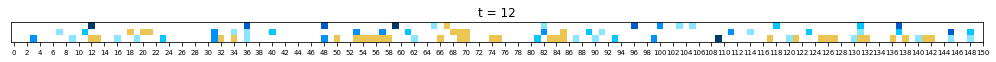

In [23]:
sim.update_simulation()
sim.draw()
#[(car.id,car.v,tuple(car.position)) for car in cars]

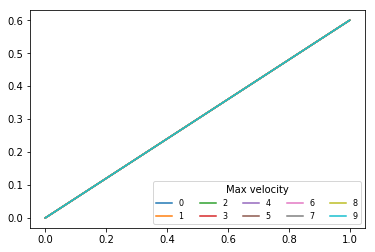

In [221]:
for _ in range(10):
    plt.plot([0,1],[0,0.6],label=_)
plt.legend(loc = 4,ncol=5,title='Max velocity',fontsize=8)

In [ ]:
sim.update_simulation()
sim.draw()

In [ ]:
road_size
#cars[5].position
#print('\n'.join(''.join('.' if x == -1 else str(x) for x in row) for row in sim.road) + "\n")
# bisect_left(sim.car_positions[cars[0].position[0]], cars[0].position[1]) % (sim.road_size-1)

# sim.car_positions[0]

# print(sim.car_positions[3])
# position_front = bisect_left(sim.car_positions[3], 40)

In [ ]:
cars[0].position, 'v=', cars[0].v, 'front gap: ', cars[0].front_gap, 'other gap: ', cars[0].left_gap

In [ ]:
cars[0].front_gap < cars[0].v + 1 and cars[0].other_gap > cars[0].v + 1 #and cars[0].back_gap > cars[0].vmax

In [ ]:
sim.car_positions[cars[0].position[0]][10]
#bisect_left(sim.car_positions[cars[0].position[0]], 120)

In [119]:
(100*np.array([x*np.ones(20) for x in np.arange(0.01,1,0.05)]).ravel()).astype(int)

1

In [99]:
round(0.0*150)

0

In [94]:
round(sim.road_size * sim.density)

90

In [109]:
round(2.5)

2

In [133]:
100*(np.arange(0.01,1,0.05))

array([ 1.,  6., 11., 16., 21., 26., 31., 36., 41., 46., 51., 56., 61.,
       66., 71., 76., 81., 86., 91., 96.])

In [134]:
(100*np.array([x*np.ones(20) for x in np.arange(0.01,1,0.05)]).ravel()).astype(int)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 26, 26,
       26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
       26, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
       36, 36, 36, 36, 36, 36, 36, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41,
       41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 46, 46, 46, 46, 46, 46, 46,
       46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 51, 51, 51, 51,
       51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 56,
       56, 56, 56, 56, 56

1

In [252]:
 np.array([[1,0]]) @ np.array([0,1])

array([0])

In [338]:
np.array(list(itertools.product(range(3),range(100))))[np.random.randint(len(list(itertools.product(range(3),range(100)))),size=8)][2]

array([ 1, 61])

In [343]:
len(np.array(list(itertools.product(range(3),range(100)))))

300

In [318]:
np.random.randint(3,size=3)

array([2, 1, 1])